In [11]:
import pandas as pd

def create_schedule_individual_fixed(file_path):
    try:
        jadwal_df = pd.read_csv(file_path, skiprows=6)
        days = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat']
        individual = []
        sesi_col = jadwal_df.columns[0]  # 'Sesi'

        for i, day in enumerate(days):
            start_col_idx = 2 + (i * 14)  # Mulai dari index ke-2 karena [0]='Sesi', [1]='WAKTU'
            end_col_idx = start_col_idx + 14
            day_cols = jadwal_df.columns[start_col_idx:end_col_idx]

            temp_df = jadwal_df[[sesi_col] + list(day_cols)].copy()
            temp_df.columns = ['Sesi', 'course_id', 'course_name', 'type',
                               'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7',
                               'I1', 'I2', 'group', 'room']
            temp_df['Hari'] = day

            # Filter baris valid
            temp_df = temp_df[temp_df['course_id'].notna() & (temp_df['course_id'] != 'Kode MK')]

            for idx, row in temp_df.iterrows():
                teachers = [row[f'D{i}'] for i in range(1, 8) if pd.notna(row[f'D{i}']) and row[f'D{i}'] != '-'] + \
                           [row[f'I{i}'] for i in range(1, 3) if pd.notna(row[f'I{i}']) and row[f'I{i}'] != '-']

                session = {
                    'class_id': f"{row['course_id']}_{idx}_{row['group']}",
                    'room': row['room'] if pd.notna(row['room']) and row['room'] != '-' else None,
                    'course_id': row['course_id'],
                    'teacher1': teachers[0] if len(teachers) > 0 else None,
                    'type': row['type'] if pd.notna(row['type']) and row['type'] != '-' else None,
                    'teacher2': teachers[1] if len(teachers) > 1 else None,  # Pastikan teacher2 kosong jika tidak ada
                    'group': row['group'] if pd.notna(row['group']) and row['group'] != '-' else None,
                    'day': row['Hari'],
                    'session': str(row['Sesi']),
                    'course_name': row['course_name'] if pd.notna(row['course_name']) and row['course_name'] != '-' else None
                }

                # Izinkan teacher2 bernilai None, tetapi pastikan field lain tidak None
                required_fields = ['class_id', 'room', 'course_id', 'teacher1', 'type', 'group', 'day', 'session', 'course_name']
                if all(session[field] is not None for field in required_fields):
                    individual.append(session)

        if not individual:
            raise ValueError("No valid sessions found.")

        return individual, None

    except FileNotFoundError:
        return None, "Dataset file not found."
    except Exception as e:
        return None, f"Data loading error: {str(e)}"

# Jalankan fungsi
file_path = "Jadwal UAS Semester Pendek  2023_2024 - Jadwal_Ujian.csv"
individual, error = create_schedule_individual_fixed(file_path)

if error:
    print(f"Error: {error}")
else:
    for session in individual[:1000]:
        print(session)

{'class_id': 'TI41101_0_41TRPL3', 'room': 'GD516', 'course_id': 'TI41101', 'teacher1': 'RIS', 'type': 'T', 'teacher2': 'MAL', 'group': '41TRPL3', 'day': 'Senin', 'session': '1.0', 'course_name': 'INDIG'}
{'class_id': 'MAS1201_2_11IF1', 'room': 'GD935', 'course_id': 'MAS1201', 'teacher1': 'YSP', 'type': 'T', 'teacher2': None, 'group': '11IF1', 'day': 'Senin', 'session': '1.0', 'course_name': 'MADAS II'}
{'class_id': 'MAS1201_4_11SI1', 'room': 'GD938', 'course_id': 'MAS1201', 'teacher1': 'ALS', 'type': 'T', 'teacher2': 'KPS', 'group': '11SI1', 'day': 'Senin', 'session': '1.0', 'course_name': 'MADAS II'}
{'class_id': 'MAS1201_6_11TE1', 'room': 'GD928', 'course_id': 'MAS1201', 'teacher1': 'ASG', 'type': 'T', 'teacher2': 'FDS', 'group': '11TE1', 'day': 'Senin', 'session': '1.0', 'course_name': 'MADAS II'}
{'class_id': 'MAS1201_8_11MR1', 'room': 'GD923', 'course_id': 'MAS1201', 'teacher1': 'SFN', 'type': 'T', 'teacher2': None, 'group': '11MR1', 'day': 'Senin', 'session': '1.0', 'course_name'

In [ ]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools
import csv

# ================================
# 2. Membaca dan Menyiapkan Data Jadwal
# ================================
def create_schedule_individual_fixed(file_path):
    try:
        jadwal_df = pd.read_csv(file_path, skiprows=6)
        days = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat']
        individual = []
        sesi_col = jadwal_df.columns[0]  # 'Sesi'
        course_id_counter = 1  # Counter untuk menghasilkan course_id unik

        for i, day in enumerate(days):
            start_col_idx = 2 + (i * 14)  # Start after 'Sesi' and 'WAKTU'
            end_col_idx = min(start_col_idx + 14, len(jadwal_df.columns))  # Prevent index out of range
            day_cols = jadwal_df.columns[start_col_idx:end_col_idx]

            # Dynamically assign column names based on available columns
            num_cols = len(day_cols)
            expected_cols = ['course_id', 'course_name', 'type', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'I1', 'I2', 'group', 'room']
            col_names = ['Sesi'] + expected_cols[:min(num_cols, len(expected_cols))]
            temp_df = jadwal_df[[sesi_col] + list(day_cols)].copy()
            temp_df.columns = col_names
            temp_df['Hari'] = day

            # Filter rows and handle missing/invalid course_id
            for idx, row in temp_df.iterrows():
                # Generate course_id if missing or invalid
                current_course_id = row.get('course_id')
                if pd.isna(current_course_id) or current_course_id == 'Kode MK' or not current_course_id:
                    current_course_id = f"C{course_id_counter:03d}"
                    course_id_counter += 1

                teachers = [row[f'D{i}'] for i in range(1, 8) if f'D{i}' in row and pd.notna(row[f'D{i}']) and row[f'D{i}'] != '-'] + \
                           [row[f'I{i}'] for i in range(1, 3) if f'I{i}' in row and pd.notna(row[f'I{i}']) and row[f'I{i}'] != '-']

                session = {
                    'class_id': f"{current_course_id}_{idx}_{row.get('group', 'unknown')}",
                    'room': row.get('room') if 'room' in row and pd.notna(row['room']) and row['room'] != '-' else None,
                    'course_id': current_course_id,
                    'teacher1': teachers[0] if len(teachers) > 0 else None,
                    'type': row.get('type') if 'type' in row and pd.notna(row['type']) and row['type'] != '-' else None,
                    'teacher2': teachers[1] if len(teachers) > 1 else None,
                    'group': row.get('group') if 'group' in row and pd.notna(row['group']) and row['group'] != '-' else None,
                    'day': row['Hari'],
                    'session': str(row['Sesi']),
                    'course_name': row.get('course_name') if 'course_name' in row and pd.notna(row['course_name']) and row['course_name'] != '-' else f"Course_{current_course_id}"
                }

                # Relaxed validation: require only course_id, day, session, and at least one teacher or room
                if session['course_id'] and session['day'] and session['session'] and (session['teacher1'] or session['room']):
                    individual.append(session)

        if not individual:
            raise ValueError("No valid sessions found after relaxed validation.")

        return individual, None

    except FileNotFoundError:
        return None, "Dataset file not found."
    except Exception as e:
        return None, f"Data loading error: {str(e)}"

# ================================
# 3. Menyiapkan Struktur Data untuk Proses Optimasi
# ================================
def prepare_schedule_data(file_path):
    individual, error = create_schedule_individual_fixed(file_path)
    if error:
        return None, None, None, None, None, None, None, None, error

    list_room_ids = sorted(list(set(session['room'] for session in individual if session['room'])))
    unique_courses = sorted(list(set(session['course_id'] for session in individual)))
    days = sorted(list(set(session['day'] for session in individual)))
    sessions = sorted(list(set(session['session'] for session in individual)))
    NUM_ROOMS = len(list_room_ids)
    NUM_DAYS = len(days)
    NUM_SLOTS_PER_DAY = len(sessions)
    TOTAL_TIMESLOTS = NUM_ROOMS * NUM_DAYS * NUM_SLOTS_PER_DAY

    lecture_schedule = {}
    lectures_to_be_scheduled = []
    teacher_mapping = {}
    for idx, session in enumerate(individual):
        lecture_id = idx + 1
        class_id = session.get('class_id', 'unknown')
        course_id = session.get('course_id', 'unknown')
        teacher1 = session.get('teacher1', 0)
        teacher2 = session.get('teacher2', 0)
        lecture_type = session.get('type', 'unknown')
        group = session.get('group', 'unknown')
        lecture_info = [class_id, course_id, teacher1, teacher2, lecture_type, group]
        lecture_schedule[lecture_id] = (lecture_info, 1)
        lectures_to_be_scheduled.append(lecture_info)
        teacher_mapping[course_id] = teacher1 or teacher2

    return (lectures_to_be_scheduled, list_room_ids, unique_courses, lecture_schedule,
            NUM_ROOMS, NUM_DAYS, NUM_SLOTS_PER_DAY, TOTAL_TIMESLOTS, None)


In [ ]:
# ================================
# 2. Membaca dan Menyiapkan Data Jadwal
# ================================
def create_schedule_individual_fixed(file_path):
    try:
        jadwal_df = pd.read_csv(file_path, skiprows=6)
        days = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat']
        individual = []
        sesi_col = jadwal_df.columns[0]  # 'Sesi'
        course_id_counter = 1  # Counter untuk menghasilkan course_id unik

        for i, day in enumerate(days):
            start_col_idx = 2 + (i * 14)  # Start after 'Sesi' and 'WAKTU'
            end_col_idx = min(start_col_idx + 14, len(jadwal_df.columns))  # Prevent index out of range
            day_cols = jadwal_df.columns[start_col_idx:end_col_idx]

            # Dynamically assign column names based on available columns
            num_cols = len(day_cols)
            expected_cols = ['course_id', 'course_name', 'type', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'I1', 'I2', 'group', 'room']
            col_names = ['Sesi'] + expected_cols[:min(num_cols, len(expected_cols))]
            temp_df = jadwal_df[[sesi_col] + list(day_cols)].copy()
            temp_df.columns = col_names
            temp_df['Hari'] = day

            # Filter rows and handle missing/invalid course_id
            for idx, row in temp_df.iterrows():
                # Generate course_id if missing or invalid
                current_course_id = row.get('course_id')
                if pd.isna(current_course_id) or current_course_id == 'Kode MK' or not current_course_id:
                    current_course_id = f"C{course_id_counter:03d}"
                    course_id_counter += 1

                teachers = [row[f'D{i}'] for i in range(1, 8) if f'D{i}' in row and pd.notna(row[f'D{i}']) and row[f'D{i}'] != '-'] + \
                           [row[f'I{i}'] for i in range(1, 3) if f'I{i}' in row and pd.notna(row[f'I{i}']) and row[f'I{i}'] != '-']

                session = {
                    'class_id': f"{current_course_id}_{idx}_{row.get('group', 'unknown')}",
                    'room': row.get('room') if 'room' in row and pd.notna(row['room']) and row['room'] != '-' else None,
                    'course_id': current_course_id,
                    'teacher1': teachers[0] if len(teachers) > 0 else None,
                    'type': row.get('type') if 'type' in row and pd.notna(row['type']) and row['type'] != '-' else None,
                    'teacher2': teachers[1] if len(teachers) > 1 else None,
                    'group': row.get('group') if 'group' in row and pd.notna(row['group']) and row['group'] != '-' else None,
                    'day': row['Hari'],
                    'session': str(row['Sesi']),
                    'course_name': row.get('course_name') if 'course_name' in row and pd.notna(row['course_name']) and row['course_name'] != '-' else f"Course_{current_course_id}"
                }

                # Relaxed validation: require only course_id, day, session, and at least one teacher or room
                if session['course_id'] and session['day'] and session['session'] and (session['teacher1'] or session['room']):
                    individual.append(session)

        if not individual:
            raise ValueError("No valid sessions found after relaxed validation.")

        return individual, None

    except FileNotFoundError:
        return None, "Dataset file not found."
    except Exception as e:
        return None, f"Data loading error: {str(e)}"

# ================================
# 3. Menyiapkan Struktur Data untuk Proses Optimasi
# ================================
def prepare_schedule_data(file_path):
    individual, error = create_schedule_individual_fixed(file_path)
    if error:
        return None, None, None, None, None, None, None, None, error

    list_room_ids = sorted(list(set(session['room'] for session in individual if session['room'])))
    unique_courses = sorted(list(set(session['course_id'] for session in individual)))
    days = sorted(list(set(session['day'] for session in individual)))
    sessions = sorted(list(set(session['session'] for session in individual)))
    NUM_ROOMS = len(list_room_ids)
    NUM_DAYS = len(days)
    NUM_SLOTS_PER_DAY = len(sessions)
    TOTAL_TIMESLOTS = NUM_ROOMS * NUM_DAYS * NUM_SLOTS_PER_DAY

    lecture_schedule = {}
    lectures_to_be_scheduled = []
    teacher_mapping = {}
    for idx, session in enumerate(individual):
        lecture_id = idx + 1
        class_id = session.get('class_id', 'unknown')
        course_id = session.get('course_id', 'unknown')
        teacher1 = session.get('teacher1', 0)
        teacher2 = session.get('teacher2', 0)
        lecture_type = session.get('type', 'unknown')
        group = session.get('group', 'unknown')
        lecture_info = [class_id, course_id, teacher1, teacher2, lecture_type, group]
        lecture_schedule[lecture_id] = (lecture_info, 1)
        lectures_to_be_scheduled.append(lecture_info)
        teacher_mapping[course_id] = teacher1 or teacher2

    return (lectures_to_be_scheduled, list_room_ids, unique_courses, lecture_schedule,
            NUM_ROOMS, NUM_DAYS, NUM_SLOTS_PER_DAY, TOTAL_TIMESLOTS, None)


In [ ]:
# ================================
# 4. Fungsi Evaluasi Konflik Jadwal
# ================================
def count_class_conflict(individual, lecture_schedule):
    timeslot_classes = {}
    for (room, slot), lecture_id in individual.items():
        if lecture_id != 0:
            timeslot_classes.setdefault(slot, set()).add(lecture_schedule.get(lecture_id, ([0, 0, 0, 0], 1))[0][0])
    return sum(max(0, len(classes) - 1) for classes in timeslot_classes.values())

def count_course_conflict(individual, lecture_schedule):
    timeslot_courses = {}
    for (room, slot), lecture_id in individual.items():
        if lecture_id != 0:
            timeslot_courses.setdefault(slot, set()).add(lecture_schedule.get(lecture_id, ([0, 0, 0, 0], 1))[0][1])
    return sum(max(0, len(courses) - 1) for courses in timeslot_courses.values())

def count_teacher_conflict(individual, lecture_schedule):
    timeslot_teachers = {}
    for (room, slot), lecture_id in individual.items():
        if lecture_id != 0:
            lecture_info = lecture_schedule.get(lecture_id, ([0, 0, 0, 0], 1))[0]
            teachers = timeslot_teachers.setdefault(slot, set())
            teachers.add(lecture_info[2])
            if lecture_info[3] != 0:
                teachers.add(lecture_info[3])
    return sum(max(0, len(teachers) - 1) for teachers in timeslot_teachers.values())

def evaluate_fitness(individual, lecture_schedule):
    class_conf = count_class_conflict(individual, lecture_schedule)
    course_conf = count_course_conflict(individual, lecture_schedule)
    teacher_conf = count_teacher_conflict(individual, lecture_schedule)
    return (class_conf, course_conf, teacher_conf)

# ================================
# 5. Inisialisasi dan Setup DEAP
# ================================
if hasattr(creator, 'FitnessMin'):
    delattr(creator, 'FitnessMin')
if hasattr(creator, 'Individual'):
    delattr(creator, 'Individual')

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0, -1.0))
creator.create("Individual", dict, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# ================================
# 6. Inisialisasi Individu Jadwal
# ================================
def init_individual(NUM_LECTURES_TO_SCHEDULE, NUM_ROOMS, NUM_DAYS, NUM_SLOTS_PER_DAY):
    schedule = {}
    lecture_ids = list(range(1, NUM_LECTURES_TO_SCHEDULE + 1))
    num_lectures = min(len(lecture_ids), NUM_LECTURES_TO_SCHEDULE)
    available_slots = NUM_ROOMS * NUM_DAYS * NUM_SLOTS_PER_DAY
    if num_lectures > available_slots:
        print(f"Warning: Reducing num_lectures from {num_lectures} to {available_slots} due to slot constraints")
        num_lectures = available_slots
    if num_lectures <= 0 or available_slots <= 0:
        print("Warning: No valid lectures or slots available")
        return schedule
    selected_lectures = random.sample(lecture_ids, num_lectures)
    slots = random.sample([(r, s) for r in range(NUM_ROOMS) for s in range(NUM_DAYS * NUM_SLOTS_PER_DAY)], num_lectures)
    for lecture_id, slot in zip(selected_lectures, slots):
        schedule[slot] = lecture_id
    return schedule


In [1]:
# ================================
# 7. Operator Crossover dan Mutasi
# ================================
def cx_dict(ind1, ind2):
    keys1, keys2 = list(ind1.keys()), list(ind2.keys())
    if not keys1 or not keys2:
        return ind1, ind2
    point = random.randint(0, min(len(keys1), len(keys2)))
    for k in keys1[:point]:
        if k in ind2:
            ind1[k], ind2[k] = ind2[k], ind1[k]
    return ind1, ind2

def mut_dict(individual, indpb=0.1, NUM_LECTURES_TO_SCHEDULE=0, NUM_ROOMS=0, NUM_DAYS=0, NUM_SLOTS_PER_DAY=0):
    for key in list(individual.keys()):
        if random.random() < indpb:
            del individual[key]
            available = [(r, s) for r in range(NUM_ROOMS) for s in range(NUM_DAYS * NUM_SLOTS_PER_DAY) if (r, s) not in individual]
            if available:
                individual[random.choice(available)] = random.choice(list(range(1, NUM_LECTURES_TO_SCHEDULE + 1)))
    return individual,

# ================================
# 8. Process Multiple CSV Files
# ================================
csv_files = [
    {"path": "JADWAL PERKULIAHAN SEMESTER GENAP 2023_2024 - Jadwal.csv", "type": "medium"},
    {"path": "JADWAL PERKULIAHAN SEMESTER PENDEK  T.A 23_24 - Jadwal.csv", "type": "low"},
    {"path": "Jadwal UAS Semester Gasal 2023_2024 - Jadwal_Ujian.csv", "type": "medium"},
    {"path": "Jadwal UAS Semester Genap 2023_2024 - Jadwal_Ujian.csv", "type": "medium"},
    {"path": "Jadwal UAS Semester Pendek  2023_2024 - Jadwal_Ujian.csv", "type": "low"},
    {"path": "Jadwal UTS Semester Gasal 2023_2024 - Jadwal_Ujian.csv", "type": "medium"},
    {"path": "Jadwal UTS Semester Genap 2023_2024 - Jadwal_Ujian.csv", "type": "medium"},
    {"path": "Jadwal UTS Semester Pendek  2023_2024 - Jadwal_Ujian.csv", "type": "low"},
    {"path": "JADWAL PERKULIAHAN SEMESTER GASAL 2023_2024 - Jadwal.csv", "type": "medium"}
]

# Store results for each file
results = []

# Process each CSV file
for file_info in csv_files:
    file_path = file_info["path"]
    schedule_type = file_info["type"]
    print(f"\nProcessing file: {file_path} (Type: {schedule_type})")

    # Load Data
    (lectures_to_be_scheduled, list_room_ids, unique_courses, lecture_schedule,
     NUM_ROOMS, NUM_DAYS, NUM_SLOTS_PER_DAY, TOTAL_TIMESLOTS, error) = prepare_schedule_data(file_path)

    if error:
        print(f"Error for {file_path}: {error}")
        results.append({
            "file": file_path,
            "type": schedule_type,
            "class_conflicts": None,
            "course_conflicts": None,
            "teacher_conflicts": None,
            "total_conflicts": None,
            "error": error
        })
        continue

    NUM_LECTURES_TO_SCHEDULE = len(lectures_to_be_scheduled)
    NUM_CLASSES = len(unique_courses)

    if NUM_ROOMS == 0 or NUM_LECTURES_TO_SCHEDULE == 0:
        print(f"Error for {file_path}: Insufficient data")
        results.append({
            "file": file_path,
            "type": schedule_type,
            "class_conflicts": None,
            "course_conflicts": None,
            "teacher_conflicts": None,
            "total_conflicts": None,
            "error": "Insufficient data"
        })
        continue

    # Register DEAP tools for this file
    toolbox.register("individual", tools.initIterate, creator.Individual,
                    lambda: init_individual(NUM_LECTURES_TO_SCHEDULE, NUM_ROOMS, NUM_DAYS, NUM_SLOTS_PER_DAY))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", lambda ind: evaluate_fitness(ind, lecture_schedule))
    toolbox.register("mate", cx_dict)
    toolbox.register("mutate", lambda ind: mut_dict(ind, indpb=0.1, NUM_LECTURES_TO_SCHEDULE=NUM_LECTURES_TO_SCHEDULE,
                                                  NUM_ROOMS=NUM_ROOMS, NUM_DAYS=NUM_DAYS, NUM_SLOTS_PER_DAY=NUM_SLOTS_PER_DAY))
    ref_points = np.array(tools.uniform_reference_points(nobj=3, p=12), dtype=np.float32)
    toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

# ================================
# 9. Fungsi Jalankan NSGA-III
# ================================
    best_fitness = float('inf')
    best_individual = None

    def run_nsga3(pop_size=50, generations=400):
        global best_fitness, best_individual
        if not lecture_schedule or not list_room_ids:
            raise ValueError("Schedule or room IDs missing")

        population = toolbox.population(n=pop_size)
        for ind in population:
            try:
                fitness_values = toolbox.evaluate(ind)
                ind.fitness.values = fitness_values
            except Exception as e:
                print(f"Error evaluating individual: {e}")
                ind.fitness.values = (float('inf'), float('inf'), float('inf'))

        for gen in range(generations):
            offspring = toolbox.select(population, len(population))
            offspring = [toolbox.clone(ind) for ind in offspring]
            for i in range(0, len(offspring), 2):
                if i + 1 < len(offspring) and random.random() < 0.9:
                    offspring[i], offspring[i + 1] = toolbox.mate(offspring[i], offspring[i + 1])
                for child in offspring[i:i + 2]:
                    if random.random() < 0.3:
                        child, = toolbox.mutate(child)
                        try:
                            child.fitness.values = toolbox.evaluate(child)
                        except Exception as e:
                            print(f"Error evaluating child: {e}")
                            child.fitness.values = (float('inf'), float('inf'), float('inf'))

            population[:] = toolbox.select(population + offspring, pop_size)

            for ind in population:
                if ind.fitness.valid and sum(ind.fitness.values) < best_fitness:
                    best_fitness = sum(ind.fitness.values)
                    best_individual = toolbox.clone(ind)

        return population, [ind.fitness.values for ind in population if ind.fitness.valid], best_individual

    # Run NSGA-III for the current file
    try:
        optimized_population_run1, fits_run1, best_ind = run_nsga3(pop_size=50, generations=500)
    except Exception as e:
        print(f"Error running NSGA-III for {file_path}: {e}")
        results.append({
            "file": file_path,
            "type": schedule_type,
            "class_conflicts": None,
            "course_conflicts": None,
            "teacher_conflicts": None,
            "total_conflicts": None,
            "error": str(e)
        })
        continue

    # Print Final Optimized Schedule Conflicts
    print(f"\nFinal Optimized Schedule Conflicts for {file_path}:")
    if best_ind and best_ind.fitness.valid:
        class_conf, course_conf, teacher_conf = best_ind.fitness.values
        total_conf = class_conf + course_conf + teacher_conf
        print(f"Total Class Conflicts: {class_conf:.0f}")
        print(f"Total Course Conflicts: {course_conf:.0f}")
        print(f"Total Teacher Conflicts: {teacher_conf:.0f}")
        print(f"Total Conflicts (Class + Course + Teacher): {total_conf:.0f}")
        results.append({
            "file": file_path,
            "type": schedule_type,
            "class_conflicts": class_conf,
            "course_conflicts": course_conf,
            "teacher_conflicts": teacher_conf,
            "total_conflicts": total_conf,
            "error": None
        })
    else:
        print("Error: No valid best individual found")
        results.append({
            "file": file_path,
            "type": schedule_type,
            "class_conflicts": None,
            "course_conflicts": None,
            "teacher_conflicts": None,
            "total_conflicts": None,
            "error": "No valid best individual found"
        })
        continue



Processing file: JADWAL PERKULIAHAN SEMESTER GENAP 2023_2024 - Jadwal.csv (Type: medium)

Final Optimized Schedule Conflicts for JADWAL PERKULIAHAN SEMESTER GENAP 2023_2024 - Jadwal.csv:
Total Class Conflicts: 1415
Total Course Conflicts: 1213
Total Teacher Conflicts: 1362
Total Conflicts (Class + Course + Teacher): 3990

Processing file: JADWAL PERKULIAHAN SEMESTER PENDEK  T.A 23_24 - Jadwal.csv (Type: low)

Final Optimized Schedule Conflicts for JADWAL PERKULIAHAN SEMESTER PENDEK  T.A 23_24 - Jadwal.csv:
Total Class Conflicts: 192
Total Course Conflicts: 102
Total Teacher Conflicts: 170
Total Conflicts (Class + Course + Teacher): 464

Processing file: Jadwal UAS Semester Gasal 2023_2024 - Jadwal_Ujian.csv (Type: medium)

Final Optimized Schedule Conflicts for Jadwal UAS Semester Gasal 2023_2024 - Jadwal_Ujian.csv:
Total Class Conflicts: 674
Total Course Conflicts: 574
Total Teacher Conflicts: 1070
Total Conflicts (Class + Course + Teacher): 2318

Processing file: Jadwal UAS Semester

Graph saved to total_conflicts_by_type_sorted_horizontal.png


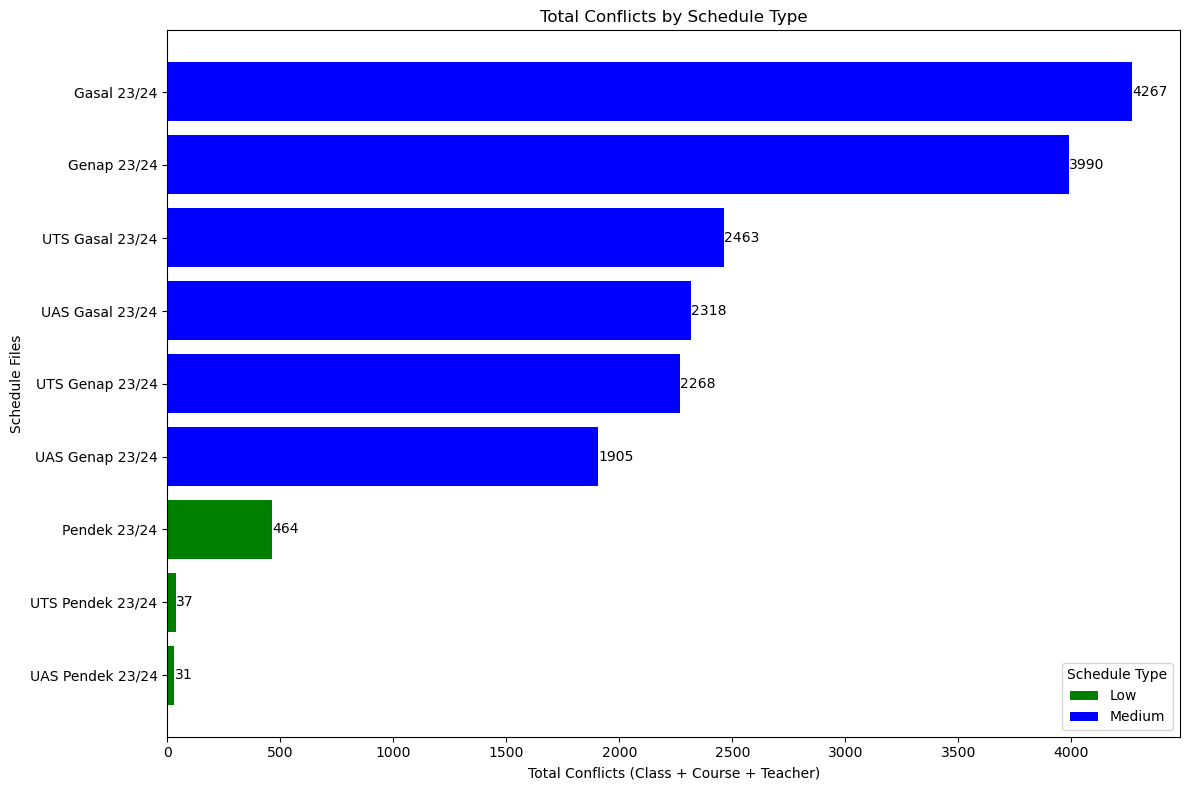

In [5]:
# ================================
# Modified Horizontal Bar Graph
# ================================
def plot_conflicts(results):
    # Filter out results with errors
    valid_results = [r for r in results if r["error"] is None and r["total_conflicts"] is not None]
    if not valid_results:
        print("No valid results to plot")
        return

    # File name mapping to shorter names
    file_name_mapping = {
        'JADWAL PERKULIAHAN SEMESTER GENAP 2023_2024 - Jadwal.csv': 'Genap 23/24',
        'JADWAL PERKULIAHAN SEMESTER PENDEK  T.A 23_24 - Jadwal.csv': 'Pendek 23/24',
        'Jadwal UAS Semester Gasal 2023_2024 - Jadwal_Ujian.csv': 'UAS Gasal 23/24',
        'Jadwal UAS Semester Genap 2023_2024 - Jadwal_Ujian.csv': 'UAS Genap 23/24',
        'Jadwal UAS Semester Pendek  2023_2024 - Jadwal_Ujian.csv': 'UAS Pendek 23/24',
        'Jadwal UTS Semester Gasal 2023_2024 - Jadwal_Ujian.csv': 'UTS Gasal 23/24',
        'Jadwal UTS Semester Genap 2023_2024 - Jadwal_Ujian.csv': 'UTS Genap 23/24',
        'Jadwal UTS Semester Pendek  2023_2024 - Jadwal_Ujian.csv': 'UTS Pendek 23/24',
        'JADWAL PERKULIAHAN SEMESTER GASAL 2023_2024 - Jadwal.csv': 'Gasal 23/24'
    }

    # Separate low and medium results
    low_files = [r for r in valid_results if r["type"] == "low"]
    medium_files = [r for r in valid_results if r["type"] == "medium"]

    # Sort by total conflicts
    low_files_sorted = sorted(low_files, key=lambda x: x["total_conflicts"] or float('inf'))
    medium_files_sorted = sorted(medium_files, key=lambda x: x["total_conflicts"] or float('inf'))

    # Prepare data for plotting
    file_names = [file_name_mapping.get(r["file"].split('/')[-1], r["file"].split('/')[-1]) 
                 for r in low_files_sorted + medium_files_sorted]
    total_conflicts = [r["total_conflicts"] for r in low_files_sorted + medium_files_sorted]
    colors = ['green' if r["type"] == "low" else 'blue' for r in low_files_sorted + medium_files_sorted]

    # Create horizontal bar plot
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(file_names)), total_conflicts, color=colors)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', label='Low'),
        Patch(facecolor='blue', label='Medium')
    ]
    plt.legend(handles=legend_elements, title="Schedule Type")
    
    # Customize plot
    plt.ylabel('Schedule Files')
    plt.xlabel('Total Conflicts (Class + Course + Teacher)')
    plt.title('Total Conflicts by Schedule Type')
    plt.yticks(range(len(file_names)), file_names)
    plt.tight_layout()

    # Add value labels at the end of bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.0f}', 
                ha='left', va='center')

    # Save and show plot
    plt.savefig('total_conflicts_by_type_sorted_horizontal.png')
    print("Graph saved to total_conflicts_by_type_sorted_horizontal.png")
    plt.show()

# Plot results
plot_conflicts(results)